In [333]:
import json
import os
from dataclasses import dataclass, field
from typing import Optional, List

import matplotlib.pyplot as plt
import pandas as pd

In [334]:
@dataclass
class StockEntry:
    """
    Класс-фасад для работы с котировками финансовых инструментов.
    """
    ticker: str
    data: pd.DataFrame = field(default_factory=pd.DataFrame)
    # кэш нормализованных данных
    ndata: Optional[pd.DataFrame] = field(default=None, init=False, repr=False)

    @classmethod
    def from_csv(cls, path: str, ticker: str = None) -> "StockEntry":
        """
        Работает с CSV-форматом:
        <TICKER>;<PER>;<DATE>;<TIME>;<OPEN>;<HIGH>;<LOW>;<CLOSE>;<VOL>;<OPENINT>

        TICKER: Название/тикер инструмента.
        PER: Период (D — день, W — неделя, M — месяц, H1 — час, MIN1 — минута).
        DATE: Дата торгов (формат YYYYMMDD).
        TIME: Время торгов (формат HHMMSS).
        OPEN: Цена открытия.
        HIGH: Максимальная цена.
        LOW: Минимальная цена.
        CLOSE: Цена закрытия.
        VOL: Объем торгов (кол-во штук).
        OPENINT: Открытый интерес (для фьючерсов).
        """
        dtypes = {
            "TICKER": "string",
            "PER": "string",
            "OPEN": "float64",
            "HIGH": "float64",
            "LOW": "float64",
            "CLOSE": "float64",
            "VOL": "float64",
            "OPENINT": "float64"
        }
        df = pd.read_csv(path, sep=";", header=0, dtype=dtypes, encoding='utf-8')
        df.columns = (
            df.columns
            .str.strip()
            .str.replace(r"[<>]", "", regex=True)  # убираем <>
            .str.upper()
        )
        df["DATE"] = pd.to_datetime(df["DATE"].astype(str), format="%Y%m%d")
        df["TIME"] = pd.to_datetime(df["TIME"].astype(str).str.zfill(6), format="%H%M%S").dt.time

        if ticker is None:
            ticker = df["TICKER"].iloc[0]
        return cls(ticker=ticker, data=df)

    def _get_normalized_data(self, splits_path: str = "./stocks/splits.json") -> pd.DataFrame:
        """
        Возвращает DataFrame с нормализованными (скорректированными) ценами и объемами, учитывая сплиты из файла `splits.json`.
        Все исторические данные пересчитываются так, чтобы текущая цена и объем соответствовали современному количеству акций.
        """
        if self.ndata is not None:
            return self.ndata

        with open(splits_path, "r", encoding="utf-8") as f:
            splits = json.load(f)

        df = self.data.copy()
        df["ADJ_FACTOR"] = 1.0

        # Если сплиты есть для тикера — применяем их
        if self.ticker in splits:
            events = sorted(splits[self.ticker], key=lambda e: e["split_date"])
            for event in events:
                split_date = pd.to_datetime(event["split_date"])
                ratio = event["ratio"]
                df.loc[df["DATE"] < split_date, "ADJ_FACTOR"] *= ratio

        for col in ["OPEN", "HIGH", "LOW", "CLOSE"]:
            df[col] = df[col] / df["ADJ_FACTOR"]

        df["VOL"] = df["VOL"] * df["ADJ_FACTOR"]

        self.ndata = df
        return df

    def get_data(self, normalized: bool = True, splits_path: str = "./stocks/splits.json") -> pd.DataFrame:
        """
        Возвращает данные по инструменту.
        normalized=False — исходные котировки.
        normalized=True — скорректированные по сплитам (требует splits_path).
        """
        if not normalized:
            return self.data

        return self._get_normalized_data(splits_path)

    def get_splits(self, splits_path: str = "./stocks/splits.json") -> list[dict]:
        """Возвращает список сплитов по тикеру из splits.json."""
        with open(splits_path, "r", encoding="utf-8") as f:
            splits = json.load(f)
        return splits.get(self.ticker, [])


In [335]:
@dataclass
class StockDB:
    """
    Класс для хранения и управления множеством котировок (QuoteData).
    """
    quotes: List[StockEntry] = field(default_factory=list)

    @classmethod
    def from_folder(cls, folder_path: str, mapping_path: str) -> "StockDB":
        """
        Загружает все CSV-файлы из указанной папки и возвращает список объектов QuoteData.
        Тикер определяется по названию файла (без расширения).
        """
        with open(mapping_path, "r", encoding="utf-8") as f:
            file_to_ticker = json.load(f)

        quotes_list: List[StockEntry] = []

        for filename in os.listdir(folder_path):
            if filename.lower().endswith(".csv") or filename.lower().endswith(".txt"):
                file_path = os.path.join(folder_path, filename)

                ticker = file_to_ticker.get(filename)
                if not ticker:
                    print(f"Не найден тикер для файла: {filename}")

                try:
                    quote = StockEntry.from_csv(file_path, ticker=ticker)
                    quotes_list.append(quote)
                    print(f"Загружен файл: {filename} (тикер: {ticker}, записей: {len(quote.data)})")
                except Exception as e:
                    print(f"Ошибка при загрузке {filename}: {e}")

        print(f"\nВсего успешно загружено: {len(quotes_list)} файлов.")
        return cls(quotes=quotes_list)

    def get_tickers(self) -> List[str]:
        """
        Возвращает список всех тикеров, содержащихся в коллекции.
        """
        return [q.ticker for q in self.quotes]

    def get_stock_entry(self, ticker: str) -> StockEntry | None:
        """
        Возвращает объект QuoteData по названию тикера.
        Если тикер не найден — возвращает None.
        """
        for quote in self.quotes:
            if str(quote.ticker).strip().lower() == ticker.strip().lower():
                return quote
        print(f"Тикер '{ticker}' не найден в коллекции.")
        return None

    def __len__(self):
        """Позволяет использовать len(collection)."""
        return len(self.quotes)

    def __getitem__(self, index: int) -> StockEntry:
        """Позволяет обращаться к элементам коллекции по индексу."""
        return self.quotes[index]

In [336]:
stockDB = StockDB.from_folder(folder_path="./stocks", mapping_path="./stocks/ticker-mappings.json")

Загружен файл: АЛРОСА_ао_1day_20111129_05092025.txt (тикер: ALRS, записей: 3459)
Загружен файл: Аэрофлот_1day_20040213_05092025.txt (тикер: AFLT, записей: 5391)
Загружен файл: ВТБ_ао_1day_20070528_05092025.txt (тикер: VTBR, записей: 4496)
Загружен файл: ГАЗПРОМ_ао_1day_20060123_05092025.txt (тикер: GAZP, записей: 4912)
Загружен файл: ЛСР_ао_1day_20071130_05092025.txt (тикер: LSR, записей: 4319)
Загружен файл: ЛУКОЙЛ_1day_20020108_05092025.txt (тикер: LKOH, записей: 5916)
Загружен файл: Магнит_ао_1day_20060516_05092025.txt (тикер: MGNT, записей: 4769)
Загружен файл: МТС_ао_1day_20040211_05092025.txt (тикер: MTSS, записей: 5384)
Загружен файл: НЛМК_ао_1day_20060418_05092025.txt (тикер: NLMK, записей: 4852)
Загружен файл: Новатэк_ао_1day_01012000_06092025.txt (тикер: NVTK, записей: 4768)
Загружен файл: НорНик_1day_20020108_05092025.txt (тикер: GMKN, записей: 149)
Загружен файл: ПИК_ао_1day_20070629_05092025.txt (тикер: PIKK, записей: 4542)
Загружен файл: Роснефть_1day_20060719_05092025.tx

# Практическое использование StocksDataCore

In [339]:
def plot_2d(
        x: List,
        y: List,
        xlabel: Optional[str] = None,
        ylabel: Optional[str] = None,
        title: Optional[str] = None,
        color: str = "tab:blue", linewidth: float = 1.8,
        grid: bool = True,
        show: bool = True
):
    """
    Простая функция для построения 2D-графика.

    Параметры:
        x: список или массив значений по оси X
        y: список или массив значений по оси Y
        xlabel: подпись оси X (опционально)
        ylabel: подпись оси Y (опционально)
        title: заголовок графика (опционально)
        color: цвет линии (по умолчанию "tab:blue")
        linewidth: толщина линии
        grid: показывать ли сетку
        show: если True, вызывает plt.show()
    """
    if len(x) != len(y):
        raise ValueError("Длины массивов X и Y должны совпадать")

    plt.figure(figsize=(12, 6))
    plt.plot(x, y, color=color, linewidth=linewidth)

    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    if title:
        plt.title(title)

    if grid:
        plt.grid(True, linestyle="--", alpha=0.6)

    plt.tight_layout()

    if show:
        plt.show()

import plotly.graph_objects as go

def plot_2d_interactive(x, y, xlabel=None, ylabel=None, title=None):
    """
    Строит интерактивный 2D-график с возможностью наведения на точки.
    """
    fig = go.Figure()

    # Добавляем линию
    fig.add_trace(go.Scatter(
        x=x,
        y=y,
        mode="lines",
        line=dict(width=2, color="royalblue"),
        hovertemplate="Дата: %{x}<br>Цена: %{y:.4f} ₽<extra></extra>"
    ))

    # Настраиваем внешний вид
    fig.update_layout(
        title=title,
        xaxis_title=xlabel,
        yaxis_title=ylabel,
        hovermode="x unified",
        template="plotly_white",
        width=1100,
        height=600
    )

    fig.show()

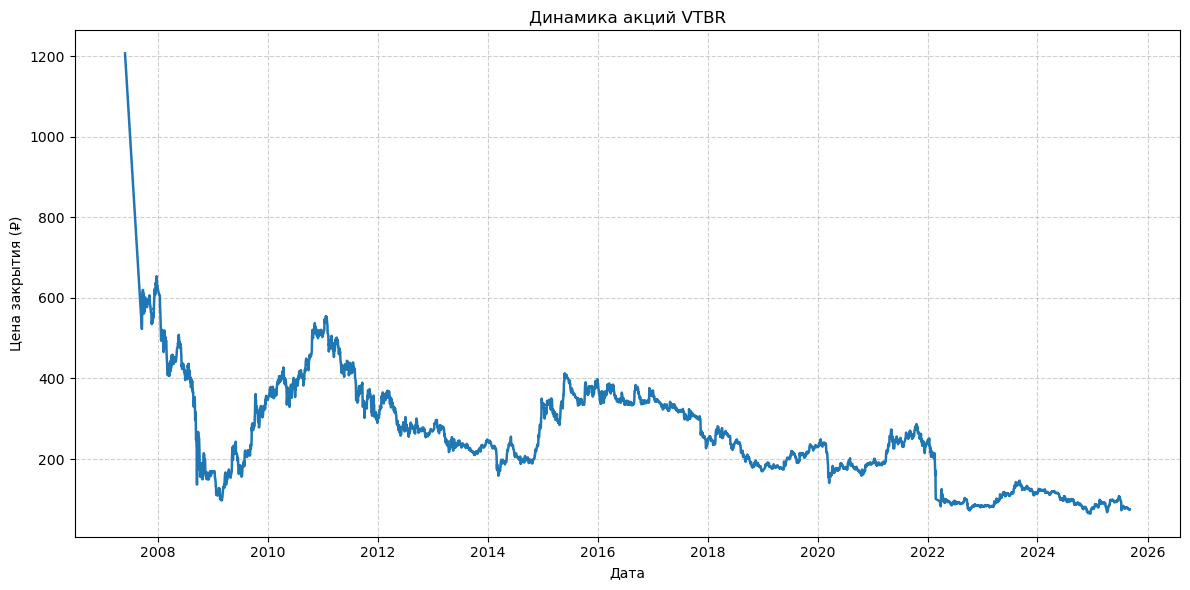

In [338]:
stock = stockDB.get_stock_entry("VTBR")
dates = stock.get_data()["DATE"]
prices = stock.get_data()["CLOSE"]

plot_2d(
    x=dates,
    y=prices,
    xlabel="Дата",
    ylabel="Цена закрытия (₽)",
    title=f"Динамика акций {stock.ticker}"
)

In [341]:
plot_2d_interactive(
    x=dates,
    y=prices,
    xlabel="Дата",
    ylabel="Цена закрытия (₽)",
    title=f"Динамика акций {stock.ticker}"
)